In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from src.config import config
from src.dataset import CustomDataset, DataTransformer
from src.engine import engine
from src.metrics import mbe
from src.model import NeuralNet
from src.utils import get_cat_emb_dims, init_random_seed

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pickle
import random

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
init_random_seed(seed=config["SEED"])

In [3]:
trainDF = pd.read_csv(config["TRAIN_DATA_PATH"], delimiter=";")
data_transformer = DataTransformer(is_train_mode=True)
processed_df = data_transformer.transform(trainDF)

In [4]:
with open("models/encoders.pickle", "wb") as f:
    pickle.dump(data_transformer.encoders, f)
with open("models/scaler.pickle", "wb") as f:
    pickle.dump(data_transformer.scaler, f)

In [5]:
# embedding columns and dimensions: cat column with more than 2 categories
emb_dims, emb_cols = get_cat_emb_dims(
    cat_data=processed_df.loc[:, data_transformer.cat_cols]
)
cont_cols = [
    c for c in processed_df.columns if c not in emb_cols and c != "install" and c != "id"
]

In [6]:
# Let's split the dataset into train, valid and test
y = processed_df.install
X = processed_df.drop("install", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, random_state=config["SEED"], stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=0.85, random_state=config["SEED"], stratify=y_train
)

In [7]:
# Create dataset instance to pass to dataloader
# Training set
train_dataset = CustomDataset(
    emb_cols=emb_cols, cont_cols=cont_cols, x=X_train, y=y_train
)

# Validation set
valid_dataset = CustomDataset(
    emb_cols=emb_cols, cont_cols=cont_cols, x=X_valid, y=y_valid
)

# Dataloader
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=config["TRAIN_BS"],
)

valid_dataloader = DataLoader(
    valid_dataset,
    sampler=SequentialSampler(valid_dataset),
    batch_size=config["VALID_BS"],
)

In [8]:
model = NeuralNet(cont_input_size=len(cont_cols), emb_dims=emb_dims)
model.to(config["DEVICE"])

NeuralNet(
  (bn1): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (emb_drop): Dropout(p=0.6, inplace=False)
  (embedding_layers): ModuleList(
    (0): Embedding(9694, 25)
    (1): Embedding(197, 25)
    (2): Embedding(34850, 25)
    (3): Embedding(223, 25)
    (4): Embedding(5, 2)
    (5): Embedding(28299, 25)
  )
  (combined_layer): Sequential(
    (0): Linear(in_features=140, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
# Model instantiation
checkpoint=None
if os.path.isfile(config["CHECKPOINT_PATH"]):
    checkpoint = torch.load(config["CHECKPOINT_PATH"])
    model.load_state_dict(checkpoint["best_state_dict"])

In [10]:
optimizer = optim.Adam(model.parameters(), lr=config["LR"])

# we're setting the positive class weight because the data is imbalanced
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
criterion.to(config["DEVICE"])

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10,
)

In [11]:
engine(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=valid_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    config=config,
    checkpoint=checkpoint
)

======================= Training Started ============================
Epoch: 4    | Elapsed Time:  54.22 s | Train Loss:  1.1867 | Valid Loss:  1.1881 | Train ROC AUC:  0.7445 | Valid ROC AUC:  0.7487 | Train MBE:  0.4018 | Valid MBE:  0.4457 | 
Epoch: 5    | Elapsed Time:  54.51 s | Train Loss:  1.1713 | Valid Loss:  1.1765 | Train ROC AUC:  0.7538 | Valid ROC AUC:  0.7486 | Train MBE:  0.3958 | Valid MBE:  0.3889 | 
Epoch: 6    | Elapsed Time:  53.87 s | Train Loss:  1.1546 | Valid Loss:  1.1753 | Train ROC AUC:  0.7619 | Valid ROC AUC:  0.7473 | Train MBE:  0.3888 | Valid MBE:  0.3960 | 
Epoch: 7    | Elapsed Time:  53.40 s | Train Loss:  1.1480 | Valid Loss:  1.1879 | Train ROC AUC:  0.7662 | Valid ROC AUC:  0.7464 | Train MBE:  0.3863 | Valid MBE:  0.3505 | 
Epoch: 8    | Elapsed Time:  52.02 s | Train Loss:  1.1440 | Valid Loss:  1.1808 | Train ROC AUC:  0.7684 | Valid ROC AUC:  0.7450 | Train MBE:  0.3839 | Valid MBE:  0.4047 | 
Epoch: 9    | Elapsed Time:  51.81 s | Train Loss:

* Model performance on test set

In [12]:
from src.train import validate
checkpoint = torch.load("models/checkpoint.pt")

In [13]:
state_dict = checkpoint["best_state_dict"]
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
test_dataset = CustomDataset(
    emb_cols=emb_cols, cont_cols=cont_cols, x=X_test, y=y_test
)

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=2000,
)

In [15]:
performance = validate(model=model, dataloader=test_dataloader, criterion=criterion, device=config["DEVICE"])

In [16]:
print(performance[0])

{'loss': 1.1856775542595208, 'roc_auc': 0.7431724729282905, 'mbe': 0.4242553971719455}


In [17]:
y_pred = [x > 0.5 for x in performance[1]]

In [18]:
from sklearn.metrics import confusion_matrix, classification_report

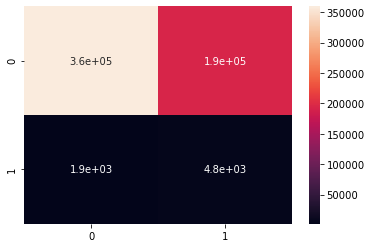

In [19]:
import seaborn as sn
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

sn.heatmap(cf_matrix, annot=True)
plt.savefig("images/confusion_matrix.png")

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79    554103
           1       0.02      0.71      0.05      6712

    accuracy                           0.65    560815
   macro avg       0.51      0.68      0.42    560815
weighted avg       0.98      0.65      0.78    560815



# Probability prediction

In [21]:
PRED_DF_PATH = "data/assessment_data.csv"
pred_df = pd.read_csv(PRED_DF_PATH, delimiter=";")
pred_df.head()

,id,timestamp,campaignId,platform,softwareVersion,sourceGameId,country,startCount,viewCount,clickCount,installCount,lastStart,startCount1d,startCount7d,connectionType,deviceType
0,5c4609b6eb7476266130c224,2019-01-21T18:04:38.028+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.2,1515907,RU,6,5,0,0,2019-01-21T17:58:23.728+00:00,6,6,wifi,LENOVO Lenovo A536
1,5c454de3a21d3edde84568d9,2019-01-21T04:43:15.681+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,2724746,MY,1,0,0,1,NaN,1,1,cellular,HUAWEI HUAWEI LUA-U22
2,5c3c4f5769db2eee0c345059,2019-01-14T08:59:03.489+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,78130,TR,49,29,4,1,2019-01-14T08:56:10.539+00:00,4,17,wifi,samsung SM-T113
3,5c4476bdf81acd685863a34f,2019-01-20T13:25:17.556+00:00,598c1d93ca9cf7103cf61dcc,android,4.4.4,1261034,TR,1,0,0,1,NaN,1,1,wifi,samsung SM-T113
4,5c456954b7d257ead2f99568,2019-01-21T06:40:20.962+00:00,598c1d93ca9cf7103cf61dcc,android,5.1,1617990,MY,7,4,0,1,2019-01-21T06:38:38.298+00:00,3,7,cellular,OPPO X9009


In [22]:
pred_df.isna().sum()

id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               281
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          275256
startCount1d            0
startCount7d            0
connectionType          0
deviceType              2
dtype: int64

In [23]:
with open("models/encoders.pickle", "rb") as f:
    encoder = pickle.load(f)
    
with open("models/scaler.pickle", "rb") as f:
    scaler = pickle.load(f)

test_data_transformer = DataTransformer(encoders=encoder, scaler=scaler,is_train_mode=False)

In [24]:
X_assessment = test_data_transformer.transform(pred_df)

In [25]:
X_assessment.head()

,id,campaignId,platform,softwareVersion,sourceGameId,country,startCount,clickCount,installCount,startCount1d,startCount7d,connectionType,deviceType,month,day,hour,minute,second,elapsed_time,countRatio
0,5c4609b6eb7476266130c224,56,0,65,12407,173,-0.467835,-0.305293,-0.367509,-0.068642,-0.394945,2,9902,0.0,1.626914,0.883179,-1.467447,0.490564,-0.307961,0.721665
1,5c454de3a21d3edde84568d9,56,0,86,27134,144,-0.523016,-0.305293,0.282660,-0.500575,-0.537978,0,7005,0.0,1.626914,-1.214912,0.782163,-0.838156,-0.309275,-1.741852
2,5c3c4f5769db2eee0c345059,56,0,71,932,198,0.006715,0.283309,0.282660,-0.241415,-0.080273,2,26673,0.0,-0.036574,-0.615457,1.705081,-1.531402,-0.308668,0.007748
3,5c4476bdf81acd685863a34f,56,0,71,6217,198,-0.523016,-0.305293,0.282660,-0.500575,-0.537978,2,26673,0.0,1.389273,0.133861,-0.256118,-0.722615,-0.309275,-1.741852
4,5c456954b7d257ead2f99568,56,0,86,15842,144,-0.456799,-0.305293,0.282660,-0.327802,-0.366339,0,13462,0.0,1.626914,-0.915185,0.609117,-0.549304,-0.308915,-0.052583


In [26]:
pred_dataset = CustomDataset(
    emb_cols=emb_cols, cont_cols=cont_cols, x=X_assessment, y=None
)
pred_dataloader = DataLoader(
    pred_dataset,
    sampler=SequentialSampler(pred_dataset),
    batch_size=2000,
)

In [27]:
from src.train import predict_proba, validate

In [28]:
predictions = predict_proba(model=model, dataloader=pred_dataloader,device=config["DEVICE"])

In [29]:
pred = [p[0] for p in predictions]

In [30]:
data = pd.DataFrame(list(zip(X_assessment.id, pred)), columns=["ID", "install_proba"])

In [31]:
data.to_csv("install_proba.csv", index=False)